In [1]:
#import statements
import cantera as ct
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import inspect
from scipy.interpolate import interp1d

In [2]:
# Geometry and pollutant injection data
lengths = [36, 13, 133, 97] # in inches
diameters = [20.5, 15.5, 10.5, 8] # in inches
lengths = [x * 0.0254 for x in lengths] # convert to meters
diameters = [x * 0.0254 for x in diameters]
measured_temps = [927,864,819,753,711,655,501,449,399,364] # °C
measured_temps_locs = [18,55,79,103,127,151,201,225,249,273] # inches
measured_temps_locs = [x * 0.0254 for x in measured_temps_locs] # convert to meters
measured_temps = [x + 273.15 for x in measured_temps] # convert to Kelvin
mdot_fuel = 0.0004855154
mdot_air = 0.0180445578
mdot_total = mdot_fuel + mdot_air
phi = 1.0
qv_air = 920
qv_fuel = 44.7
Qv_tot = qv_air + qv_fuel
pollutant = "PF8acid"
concentration = 0.01 # mole fraction
injection_position = 0.5 # meters, adjust as necessary

In [3]:
#make line number function
def lineno():
    """Returns the current line number in our program."""
    return inspect.currentframe().f_back.f_lineno

In [4]:
# Generate a Flame using FreeFlame
A=np.pi * (diameters[0]*0.0254/2)**2
u_inlet = Qv_tot / (A * 60)
normalized_locs = [loc / measured_temps_locs[-1] for loc in measured_temps_locs]

flame_gas = ct.Solution('gri30.yaml')

Y_constant = np.ones(len(flame_gas.species_names))/len(flame_gas.species_names)

# Expand the measured_temps data to have the same shape as Y_constant
expanded_temps = np.repeat(measured_temps, len(flame_gas.species_names)).reshape(-1, len(flame_gas.species_names))

# Tile the Y_constant to match the shape of expanded_temps
Y_expanded = np.tile(Y_constant, (10, 1))

data = np.column_stack((expanded_temps, Y_expanded))

flame_gas.set_equivalence_ratio(phi=1.0, fuel='CH4', oxidizer='O2:0.21, N2:0.79')

f = ct.FreeFlame(flame_gas)

f.transport_model = 'Mix'

f.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

domain_length = f.grid[-1]

w = np.linspace(0, domain_length, len(f.grid))

T_guess = np.interp(w, measured_temps_locs, measured_temps)

f.T[:]= T_guess


c:\Users\KWILKES\AppData\Local\Programs\Python\Python310\lib\site-packages\cantera\onedim.py:231: DeprecationWarning: FactoryBase::canonicalize: Model name 'Mix' is deprecated. Use 'mixture-averaged' instead.
  self.flame.transport_model = model


In [5]:
# Solve for the flame structure
ER = phi**-1

fname = 'files/flames/'+'flame_'+str(phi)+'.yaml'
if os.path.exists(fname) == False:
    print('flame solution does not exist for input SR -> solving flame...')
    f.solve(auto=True, loglevel=5)
    f.gas.write_yaml(fname)

# Store the temperature profile
T_profile = f.T

flame solution does not exist for input SR -> solving flame...

************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...

Damped Newton iteration:
-----------------------------------------------------------------
m     F_damp     F_bound     log10(ss)   log10(s0)   log10(s1)  N_jac   Age
-----------------------------------------------------------------

Newton step takes solution out of bounds.

        domain     component    pt       value        step         min         max
             1             H     3   7.151e-06  -9.094e-06  -1.000e-07   1.000e+05
             1             O     3   6.268e-05  -8.803e-05  -1.000e-07   1.000e+05
             1           HO2     2   1.662e-22  -2.052e-06  -1.000e-07   1.000e+05
             1           HO2     3   2.993e-07  -4.566e-06  -1.000e-07   1.000e+05
             1          H2O2     

In [6]:
# Load the pollutant mechanism
pollutant_gas = ct.Solution('NCSU_PFASmech1.0.yaml')

# Assume some initial conditions for the pollutant gas (Modify as needed)
pollutant_gas.TPX = T_profile[-1], f.P, "PF8acid:1.0"
species = pollutant_gas.species('PF8acid')

# Setting up reactors for pollutant reactions using the T_profile
reactors = []
for i, T in enumerate(T_profile):
    pollutant_gas.TPX = T, f.P, "PF8acid:1.0"
    reactor = ct.IdealGasReactor(pollutant_gas)
    reactors.append(reactor)
    if i > 0:
        ct.MassFlowController(upstream=reactors[i-1], downstream=reactor, mdot=mdot_total)

In [7]:
# Setup the simulation
z = 0

for i, (L, D) in enumerate(zip(lengths, diameters)):
    area = np.pi * (D/2)**2
    volume = area * L
    pollutant_gas.TPY = T_profile[i], ct.one_atm, pollutant_gas.Y
    r = ct.IdealGasReactor(pollutant_gas, energy='on')
    r.volume = volume

    if z <= injection_position < (z + L):
        pollutant_gas.set_equivalence_ratio(phi=phi, fuel={pollutant: 1.0}, oxidizer='O2:0.21, N2:0.79')
        # Check the current mole fraction of the pollutant
        current_concentration = pollutant_gas.X[pollutant_gas.species_index(pollutant)]
        new_concentration = current_concentration + concentration
        pollutant_gas.set_equivalence_ratio(phi=phi, fuel={pollutant: new_concentration}, oxidizer='O2:0.21, N2:0.79')

    reactors.append(r)
    z += L

In [8]:
# Connect reactors in series
for i in range(len(reactors)-1):
    ct.Wall(left=reactors[i], right=reactors[i+1], A=area)
    ct.MassFlowController(upstream=reactors[i], downstream=reactors[i+1], mdot=mdot_total)

In [9]:
# Do simulation of pollutant reactions
sim = ct.ReactorNet(reactors)
print(lineno())
sim.verbose = True
print(lineno())
current_time = 0.0
end_time = 20.0
initial_time_increment = 0.001
max_time_increment = 0.1
time_increment = initial_time_increment

while current_time < end_time:
    try:
        current_time += time_increment
        sim.advance(current_time)
        time_increment = min(time_increment * 2, max_time_increment)
    except Exception:
        time_increment /= 2
        print(lineno())
        sim.reinitialize()
        print(lineno())
    print(f"At time {current_time:1.2e} s, the pollutant concentration is {pollutant_gas.X[pollutant_gas.species_index(pollutant)]:1.2e} mole fraction, and the temperature is {reactors[0].thermo.T:.2f} K.")
    print('-' * 50)

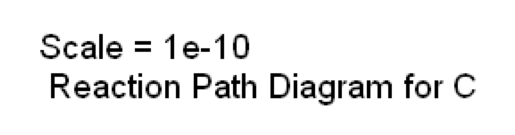

In [ ]:
# Path Diagram
element_or_species = "C"
diagram = ct.ReactionPathDiagram(pollutant_gas, element_or_species)
diagram.title = f"Reaction Path Diagram for {element_or_species}"
diagram.label_threshold = 0.01

# Save the diagram in DOT format
filename_without_extension = "reaction_path"
diagram.write_dot(f"{filename_without_extension}.dot")

# Convert DOT to PNG using Graphviz
os.system(f"dot {filename_without_extension}.dot -Tpng -o {filename_without_extension}.png")

# Display the PNG using matplotlib
img = mpimg.imread(f"{filename_without_extension}.png")
plt.imshow(img)
plt.axis('off') # Hide axes
plt.show()

In [ ]:
T_peak = max(T_profile)
print(T_peak)

300.0
